In [1]:
#Import libraries to notebook
import mne
import torch
import matplotlib.pyplot as plt
import numpy             as np
import torch.nn          as nn

from torch.utils.data                          import DataLoader
from eeg_lib.commons.constant                  import DATASETS_FOLDER
from eeg_lib.data.data_loader.EEGDataExtractor import EEGDataExtractor
from eeg_lib.data.data_setup                   import TripletEEGDataset
from eeg_lib.models.verification.EEGNet        import EEGNetEmbeddingModel
from eeg_lib.utils.helpers                     import split_train_test

from eeg_lib.utils.engine import (
    train_triplet_model,
    extract_embeddings,
    create_user_profiles,
    verify_test_sample,
)

from eeg_lib.utils.visualisations import (
    visualize_umap,
    visualize_tsne,
    calculate_and_plot_distances,
)

c:\Users\HP\Desktop\Neuroguard\artificial-intelligence\notebooks\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Import dataset to notebook
DATA_DIR                  = f"{DATASETS_FOLDER}/Kolory/"
extractor                 = EEGDataExtractor(data_dir=DATA_DIR)
eeg_df, participants_info = extractor.extract_dataframe()

In [3]:
#Check first lines of dataset
eeg_df.head()

,participant_id,epoch,label
0,011595b1@1651,"[[1.5994905899983496e-06, 4.660259780289654e-0...",gray
1,011595b1@1651,"[[3.2936710911247503e-06, 3.745427511069207e-0...",green
2,011595b1@1651,"[[4.327731927482567e-06, 2.515285592381088e-06...",gray
3,011595b1@1651,"[[1.7759480686267016e-06, -3.0099938072414544e...",red
4,011595b1@1651,"[[4.0924612078715145e-06, 4.532130983695527e-0...",gray


In [4]:
#Check number of all records
eeg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6960 entries, 0 to 6959
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  6960 non-null   object
 1   epoch           6960 non-null   object
 2   label           6960 non-null   object
dtypes: object(3)
memory usage: 163.3+ KB


In [5]:
#Check numbers of channels and samples
sample_epoch = eeg_df["epoch"].iloc[0]
sample_epoch.shape

(4, 751)

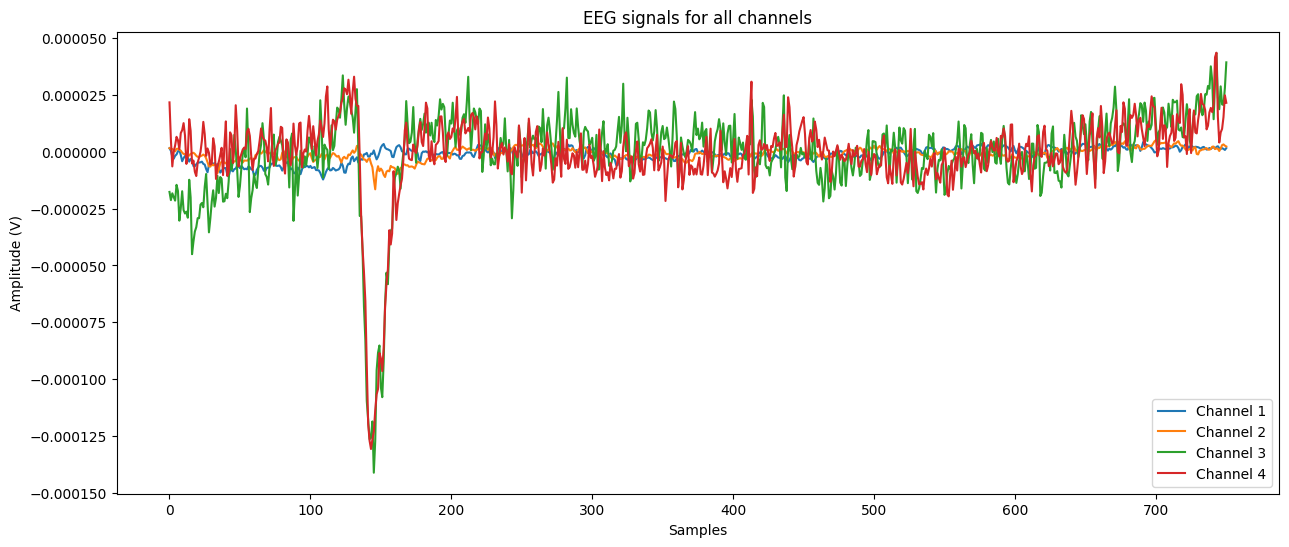

In [6]:
#Show plot with sample values from all 4 channels

plt.figure(figsize=(15, 6))
for channel in range(sample_epoch.shape[0]):
    plt.plot(sample_epoch[channel], label=f"Channel {channel+1}")
plt.title("EEG signals for all channels")
plt.xlabel("Samples")
plt.ylabel("Amplitude (V)")
plt.legend(loc="lower right")
plt.show()

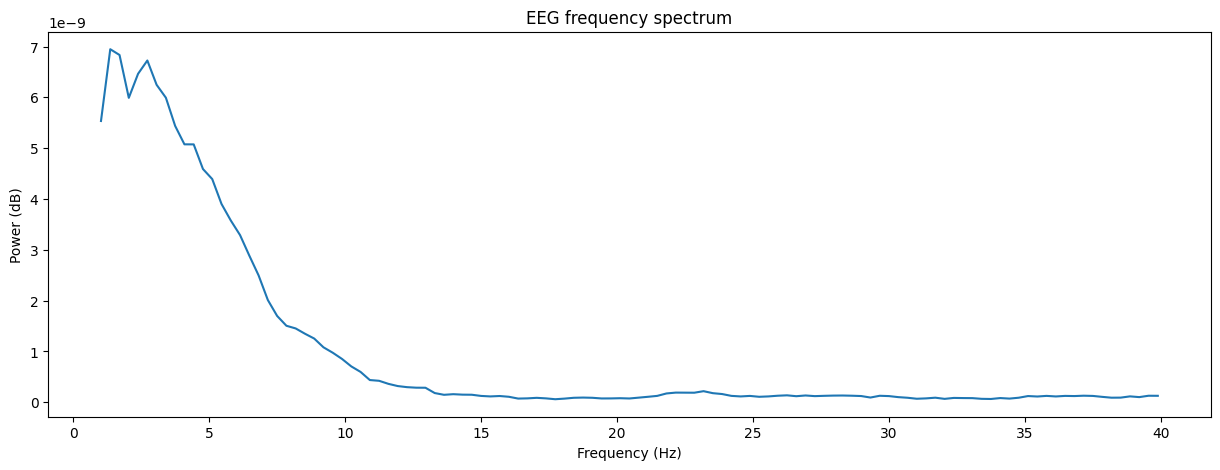

In [7]:
#Show plot with frequency spectrum values
epochs      = eeg_df["epoch"].iloc[0]
sfreq       = 256  
psds, freqs = mne.time_frequency.psd_array_multitaper(epochs, sfreq=sfreq, fmin=1, fmax=40)

plt.figure(figsize=(15, 5))
plt.plot(freqs, np.mean(psds, axis=0))
plt.title("EEG frequency spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.show()

In [8]:
#Split dataset for training and testing parts

train_df, test_df, train_participants, test_participants = split_train_test(
    eeg_df=eeg_df, test_size=0.30, random_state=42
)

triplet_train_dataset = TripletEEGDataset(train_df)
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=8, shuffle=True)

#Initialize model

model = EEGNetEmbeddingModel(
    num_channels=4, num_time_points=751, num_classes=32, embedding_dimension=32
)

NUM_EPOCHS      = 10
triplet_loss_fn = nn.TripletMarginLoss(margin=0.05)
optimizer       = torch.optim.Adam(model.parameters(), lr=1e-3)

Training set participants: ['011595b1@1651' '2718372d@1400' '6e542bc2@0845' '2882ae26@1441'
 '548fd734@1628' '51ec2c20@0923' 'bf2d2193@1638' '022e8467@1910'
 '06f240e9@1215' 'e283301e@1606' '25d0bdb3@1318' 'b34b1427@0906'
 'e43a9f9f@0941' '8dca0725@1418' 'ffae50df@1712' '9e8bae0e@1828'
 '36eea4bb@1519' '46607ce4@1717' '54e60118@1339' '90441f44@1643'
 '3033b74a@1626']
Test set participants: ['f82b5699@1757' '6d9a8b86@1613' 'd87e1bd3@1806' '8bd3032e@1746'
 '39285860@1825' '446b3735@1618' 'fd8a3308@1135' 'e08138e2@1731'
 '541c91f2@1456']


In [9]:
#Training and testing model

results, _ = train_triplet_model(
    model, triplet_train_loader, triplet_loss_fn, optimizer, NUM_EPOCHS
)

c:\Users\HP\Desktop\Neuroguard\artificial-intelligence\notebooks\venv\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


Epoch 1, Average Loss: 0.1006
Epoch 2, Average Loss: 0.0795
Epoch 3, Average Loss: 0.0552
Epoch 4, Average Loss: 0.0477
Epoch 5, Average Loss: 0.0310
Epoch 6, Average Loss: 0.0256
Epoch 7, Average Loss: 0.0216
Epoch 8, Average Loss: 0.0218
Epoch 9, Average Loss: 0.0211
Epoch 10, Average Loss: 0.0201


In [10]:
#Save model
torch.save(model.state_dict(), f"./model.pth")

In [11]:
# Check sample

embeddings_array, participant_ids_array = extract_embeddings(model, test_df)
user_profiles                           = create_user_profiles(embeddings_array, participant_ids_array)
sample_index                            = 0
threshold                               = 0.87

accepted, distance = verify_test_sample(
    test_df, model, user_profiles, sample_index, threshold
)

print(f"Sample {sample_index} verification result: {'Accepted' if accepted else 'Rejected'}, Distance: {distance}")

Sample 0 verification result: Accepted, Distance: 0.09279406815767288


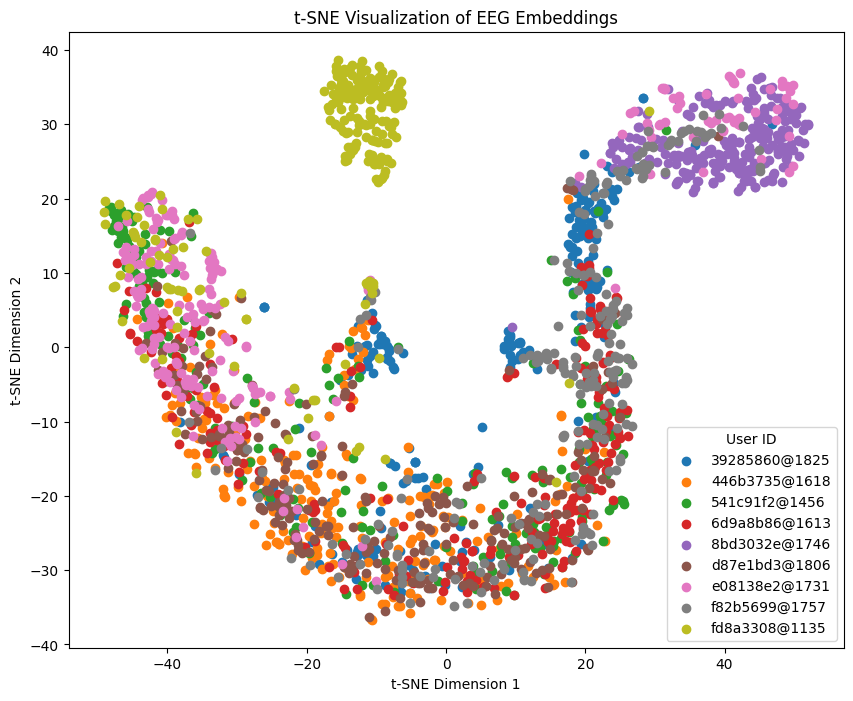

In [12]:
#Show TSNE
visualize_tsne(embeddings_array, participant_ids_array)

c:\Users\HP\Desktop\Neuroguard\artificial-intelligence\notebooks\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\Neuroguard\artificial-intelligence\notebooks\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


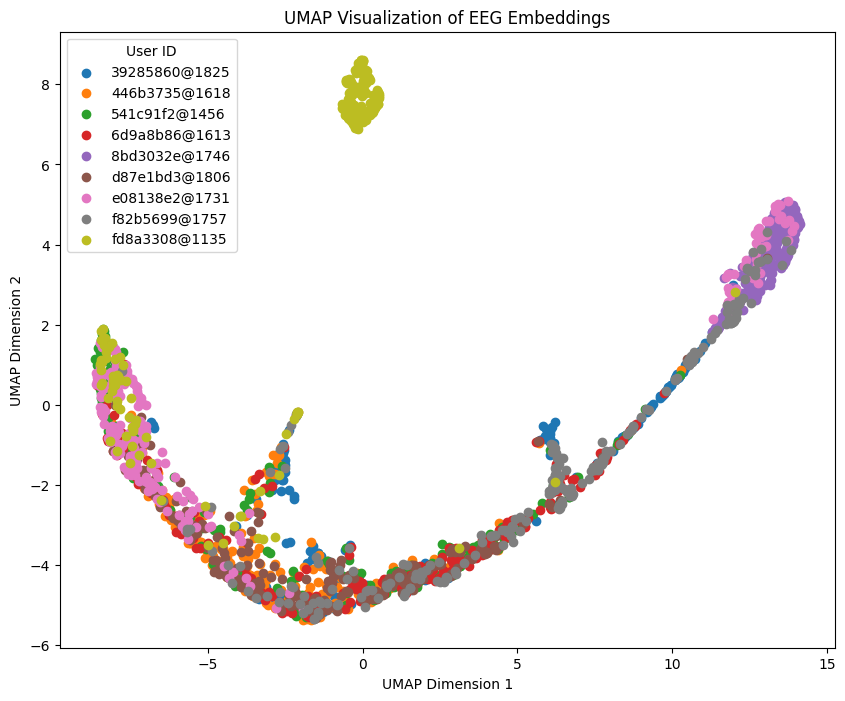

In [13]:
#Show UMAP
visualize_umap(embeddings_array, participant_ids_array)

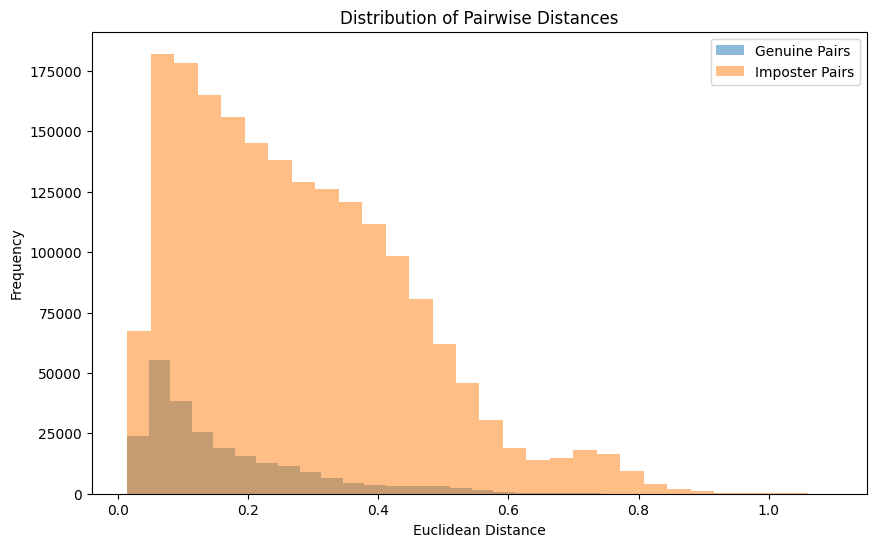

In [14]:
#Show plot with distances
genuine_distances, imposter_distances = calculate_and_plot_distances(
    embeddings_array, participant_ids_array
)